## Advanced Optoelectronic Devices 2023
# Computational <span style="color:red">Simulation</span> and <span style="color:blue">Analysis</span> of Nanoscale Devices

### Dr Joe Smith  (email: j.smith@bristol.ac.uk)

In [18]:
# Preable: Import numerical and plotting packages, link to Lumerical API

import numpy as np
import matplotlib.pyplot as plt
import imp

plt.rcParams['figure.figsize'] = [12, 6]


LUMERICAL_VERSION = "2023b" 
lumapi = imp.load_source("lumapi", r"C:\Program Files\Lumerical\{0}\api\python\lumapi.py".format(LUMERICAL_VERSION))


### Lecture contents <a name = "contents"></a>
1. [Introduction](#introduction)
    1. [Launching Lumerical](#lumerical)
    2. [Defining a structure](#structure) 
3. [1D Mode solving](#1dmode)
    1. [Defining a simulation region](#1dsim)
    2. [Extracting mode data](#1ddata)
    3. [Performing a parameter sweep](#1dparam)
    4. [Modelling thickness and effective index](#1dthick)
    5. [Simulation convergence](#1dconverg)
    6. [TE / TM Polarisation](#TETMpolarisation)
3. [2D Mode solving](#2dmode)
    1. [Defining a simulation region](#2dsim)
    2. [TE / TM](#2dTE)
    3. [Advanced structures](#adv)

## Introduction to computational techniques in Lumerical MODE <a name="introduction"></a> [^](#contents)

In this lecture, we will examine the power of computational techniques to simulate electromagnetic devices.

We will use **Lumerical MODE** to solve the electromagnetic eigenmodes of highly complex structures. In Lumerical MODE, space is digitised into a finite mesh before Maxwell's equations are solved. This numerical technique has the advantage of providing rapid solutions where analytical calculations would otherwise fail.  

![discrete_image]( https://edadocs.software.keysight.com/download/attachments/6924982/conformal_mesh.gif?version=1&modificationDate=1477154422000&api=v2)

In parallel, we will gain confidence in extracting and analysing computation data in Python to get intuition behind the building blocks of integrated photonic circuits. 

### Launching Lumerical <a name="lumerical"></a>

Firstly, we will launch a Lumerical MODE session using the Python API imported above. This can take a minute, wait until the application launches and the cell is no longer asterisked.



In [19]:
mode = lumapi.MODE()

Exception ignored in: <function Lumerical.__del__ at 0x00000196FC8BDEE8>
Traceback (most recent call last):
  File "C:\Program Files\Lumerical\2019b\api\python\lumapi.py", line 1184, in __del__
    close(self.handle)
  File "C:\Program Files\Lumerical\2019b\api\python\lumapi.py", line 252, in close
    iapi.appClose(handle)
ctypes.ArgumentError: argument 1: <class 'TypeError'>: expected Session instance instead of Session


By executing this code, a correctly linked API should launch a new session of Lumerical MODE on your computer. Using calls in this notebook, we can create and modify structures in this GUI which will allow us to perform automated sweeps on device parameters. 

### Defining a waveguide structure<a name="structure"></a>

Firstly, we will create a waveguide by defining a dielectric with a refractive index of glass. Executing the code below will draw the waveguide structure into the simulation window. 

In [20]:

wg_thickness = 1.5e-6 # waveguide thickness

custom = "<Object defined dielectric>"
refractive_index = 1.4 # Index of glass

mode.addrect()
mode.set('name','waveguide')

mode.setnamed('waveguide','z max', wg_thickness)
mode.setnamed('waveguide','z min', 0)
mode.setnamed('waveguide','y', 0)
mode.setnamed('waveguide','y span', 1.5e-6)
mode.setnamed('waveguide','x', 0)
mode.setnamed('waveguide','x span', 20e-6)
mode.set('material',custom)
mode.set('index',refractive_index)

## 1D Mode solving<a name="1dmode"></a> [^](#contents)

With this dielectric object, we can solve the electromagnetic modes that can propagate at a given wavelength by defining a simulation region and a wavelength of interest. 


### Defining a 1D simulation region<a name="1dsim"></a>

For this first simulation, we define a 1D simulation region and look at 636 nm -- the wavelength of red light. 

In [21]:
wavelength = 637e-9
meshsize = 10e-9 # size of mesh cell

head_space = 1e-6 # space above/below wg for simulation region 

zmin = -head_space
zmax = wg_thickness + head_space

mode.addfde()
mode.set("solver type","1D Z:X prop")
mode.set("x", 0), mode.set("y", 0)
mode.set("z max", zmax), mode.set("z min", zmin)
mode.set("wavelength", wavelength)
mode.set("define z mesh by","maximum mesh step")
mode.set("dz", meshsize)
modes=4 # modes to output
mode.set("number of trial modes",modes)

In the GUI interface we can see the software has created a 1D cut through the rectangle defined, representing the simulation region.

In general, it is best practise to consider the minimum dimensionality required to capture the physics we are interested, in order to have an efficent simulation. For instance, simulating the full 3D waveguide would take exponentially longer to compute, prevent quick sweeps of interesting parameters.

### Extracting mode simulation data<a name="1ddata"></a>

In the cell below, we compute the mode for the thickness defined. We do this by extracting the mode data required from the finished solution, in this case the z dimension meshed by the simulation region, the y-component of the electric field, and the refractive index of the simulation region. 

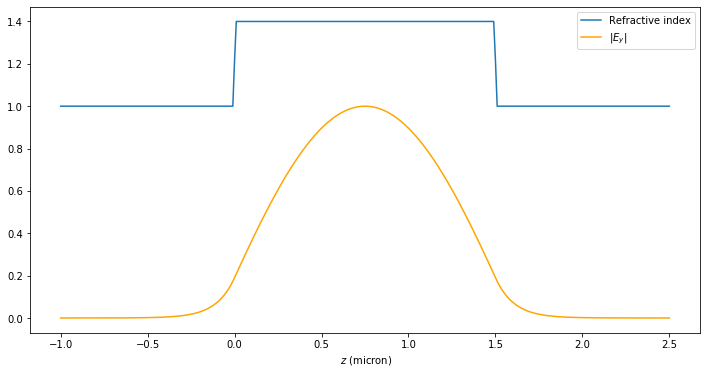

In [22]:

mode.findmodes()

Ey = mode.getdata("MODE::data::mode1","Ey")
refractive_index =mode.getdata("MODE::data::material","index_z") # extract refractive index
z = mode.getdata("MODE::data::mode1","z")*1e6 # scale into microns

plt.plot(z,np.real(refractive_index.flatten()),label='Refractive index')
plt.plot(z,np.real(Ey.flatten()),'-',label='$|E_y|$',color='orange')

plt.xlabel(' $z$ (micron)')
plt.legend()
plt.show()

We see that the electric field mode is confined by the dielectric boundary of the waveguide.

    
### Performing a parameter sweep <a name="1dparam"></a>

Now we know how to setup a basic simulation, run it, then extract and plot data to show its results.

What will happen if the waveguide is larger? What will happen if the waveguide is smaller?

For the next stage, the real power of computational techniques is introduced. 

We could change the waveguide thickness and solve it stage by stage. A much more powerful technique is to write a script to perform this *parameter sweep* automatically, modifying the physical structure and extract the results after each iteration. 


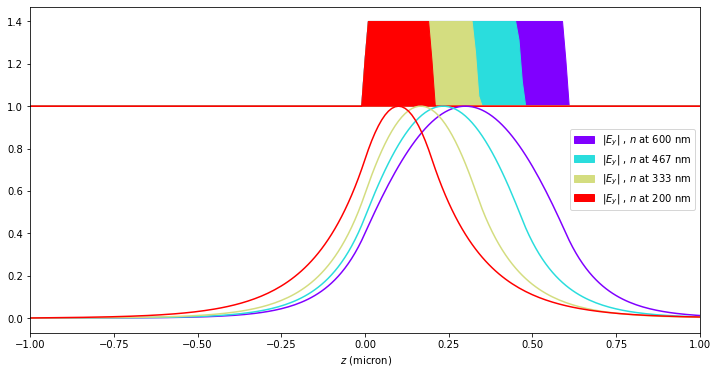

In [23]:
wg_thick_array = np.linspace(0.6e-6,0.2e-6,num=4)

color=iter(plt.cm.rainbow(np.linspace(0,1,4)))

for thickness in wg_thick_array:
    c=next(color)

    mode.switchtolayout()
    mode.setnamed('waveguide','z max', thickness)

    mode.findmodes()

    Ey = mode.getdata("MODE::data::mode1","Ey")
    refractive_index =mode.getdata("MODE::data::material","index_z") # extract refractive index
    z = mode.getdata("MODE::data::mode1","z")*1e6 # scale into microns

    plt.fill(z,np.real(refractive_index.flatten()),label='$|E_y|$ , $n$ at {0:.0f} nm'.format(thickness*1e9),color=c)
    plt.plot(z,np.real(Ey.flatten()),'-',color=c)
    
plt.xlabel(' $z$ (micron)')
plt.xlim([-1,1])
plt.legend()
plt.show()


### Modelling thickness and effective index <a name="1dthick"></a>

We see that dependent on the thickness of the dielectric, the mode propagates more or less in the higher refractive index dielectric. This is parameterised by the "effective index" of the mode $$n_{eff} = \frac{\beta}{k_0}$$. To model the trend, we will extract the effective index at each point




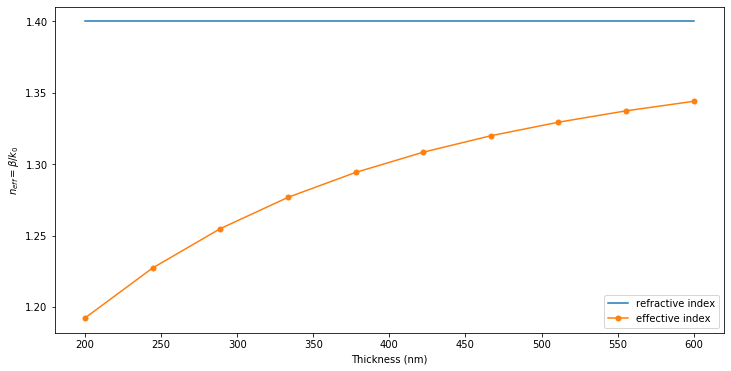

In [24]:
wg_thick_array = np.linspace(0.6e-6,0.2e-6,num=10)
effective_index = np.zeros(np.shape(wg_thick_array))

for i, thickness in enumerate(wg_thick_array):
    mode.switchtolayout()
    mode.setnamed('waveguide','z max', thickness)
    mode.findmodes()
    refractive_index =np.max(mode.getdata("MODE::data::material","index_z").flatten())
    effective_index[i] = np.real(mode.getdata("MODE::data::mode1","neff").flatten()[0])

refractive_index = refractive_index* np.ones(np.shape(wg_thick_array))
plt.plot(1e9*wg_thick_array, refractive_index,label='refractive index')
plt.plot(1e9*wg_thick_array, effective_index,'.-',label='effective index',markersize=10)
plt.ylabel(r'$n_{eff} = \beta/k_0$')
plt.xlabel('Thickness (nm)')
plt.legend()
plt.show()



### Simulation convergence  <a name="1dconverg"></a>

One important point to note at this point is that the simulation region size is chosen away from the boundary of the dielectric waveguide. To see why this is important, let's model the calculated effective index as the simulation region is reduced. 

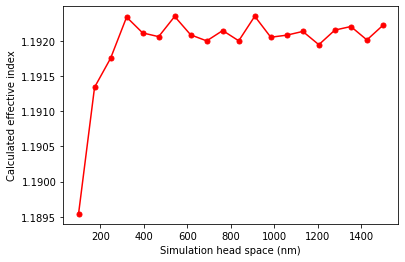

In [96]:
# Simulation volume code

headspace_array = np.linspace(0.1e-6,0.15e-5,num=20)
effective_index = np.zeros(np.shape(headspace_array))

wg_thickness = 0.4e-6

for i, headspace in enumerate(headspace_array):
    mode.switchtolayout()    
    mode.setnamed("FDE","z max", wg_thickness+headspace)
    mode.findmodes()
    effective_index[i] = np.real(mode.getdata("MODE::data::mode1","neff").flatten()[0])
    
plt.plot(headspace_array*1e9, effective_index,'r.-',markersize=10)
plt.xlabel('Simulation head space (nm)')
plt.ylabel('Calculated effective index')
plt.show()

### TE/TM Modes  <a name="TETMpolarisation"></a>

As well as the first mode plotted before, we can search for further n modes using the eigenmode solver.

In this case, we will see that if we look at mode 2 we can compare it with mode 1 in terms of polarisation and assign it TE or TM.

$\text{TE polarization fraction (Ey)} = \frac{\int |Ey|^2 dydz}{\int (|Ey|^2+|Ez|^2) dydz}$


_( NB. definitions in Lumerical are often worth double checking, this assumes propagation in the x-direction, as in our model https://support.lumerical.com/hc/en-us/articles/360034396734)_


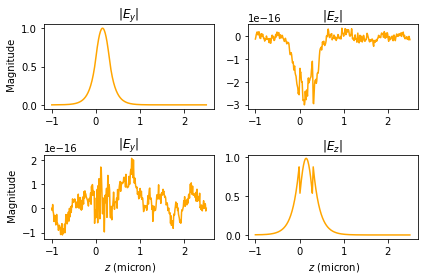

In [10]:
mode.switchtolayout()
mode.setnamed('waveguide','z max', 0.3e-6)
mode.findmodes()

refractive_index =mode.getdata("MODE::data::material","index_z") # extract refractive index
z = mode.getdata("MODE::data::mode1","z")*1e6 # scale into microns

fig, ax = plt.subplots(2,2)

#plt.plot(z,np.real(refractive_index.flatten()),label='Refractive index')

Ey = mode.getdata("MODE::data::mode1","Ey")
Ez = mode.getdata("MODE::data::mode1","Ez")


ax[1,0].set_xlabel(' $z$ (micron)')
ax[1,1].set_xlabel(' $z$ (micron)')

ax[0,0].set_ylabel(' Magnitude')
ax[1,0].set_ylabel(' Magnitude')

ax[0,0].plot(z,np.real(Ey.flatten()),'-',label='$|E_y|$',color='orange')
ax[0,0].set_title('$|E_y|$')

ax[0,1].plot(z,np.real(Ez.flatten()),'-',label='$|E_z|$',color='orange')
ax[0,1].set_title('$|E_z|$')

Ey = mode.getdata("MODE::data::mode2","Ey")
Ez = mode.getdata("MODE::data::mode2","Ez")

ax[1,0].plot(z,np.real(Ey.flatten()),'-',label='$|E_y|$',color='orange')
ax[1,0].set_title('$|E_y|$')

ax[1,1].plot(z,np.real(Ez.flatten()),'-',label='$|E_z|$',color='orange')
ax[1,1].set_title('$|E_z|$')


fig.tight_layout()

plt.show()

## 2D mode solving  <a name="2dmode"></a> [^](#contents)

Naturally, as well as solving the mode in 1D, 2D or even 3D simulations can be considered.
        
Here we will consider a 2D simulation region. The simulation for this simple suspended glass rod waveguide will not add any extra information but will take longer to solve.

### Defining a simulation region  <a name="2dsim"></a>

For this, we need to delete our 1D simulation region and create a new one as only a single simulation region is supported. 




In [11]:
# 2D mode code

mode.switchtolayout()

head_space = 1e-6 # space above/below wg for simulation region 
wg_thickness = 0.5e-6
zmin = -head_space
zmax = wg_thickness + head_space

waveguide_y = np.array([-wg_thickness/2, wg_thickness/2])*1e6
waveguide_z = np.array([0, wg_thickness])*1e6


mode.setnamed("waveguide","z max", wg_thickness), mode.setnamed("waveguide","z min", 0)
mode.setnamed("waveguide", "y span", wg_thickness)


mode.delete('FDE')
mode.addfde()
mode.set("solver type","2D X normal")
mode.set("x", 0), mode.set("y", 0)
mode.set("z max", zmax), mode.set("z min", zmin)
mode.set("y span", zmax)
mode.set("wavelength", wavelength)
mode.set("define z mesh by","maximum mesh step")
mode.set("dz", meshsize)
mode.set("number of trial modes",4)

simulation_area = np.array([zmin,zmax, -zmax/2, zmax/2])*1e6

mode.findmodes()

4.0

### Plotting TE/TM in 2D <a name="2dTE"></a>

Instead of extracting data and plotting line plots, we can plot images or slices as the data is now an array that must be reshaped to the 2D simulation region.

Similar to before, we can plot the $E_y$ and $E_z$ components of the electric field to determine the polarisation of the solved modes. 

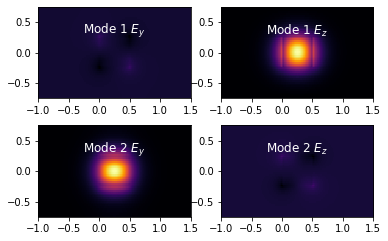

In [12]:
# Get position data
y = mode.getdata("MODE::data::mode1","y").flatten()
z = mode.getdata("MODE::data::mode1","z").flatten()


fig, ax = plt.subplots(2,2)

# Mode 1
Ey = np.reshape(mode.getdata("MODE::data::mode1","Ey"), ( np.shape(y)[0], np.shape(z)[0]))
Ez = np.reshape(mode.getdata("MODE::data::mode1","Ez"), ( np.shape(y)[0], np.shape(z)[0]))


ax[0,0].imshow(np.real(Ey), extent =simulation_area, cmap='inferno',vmax=1 )
ax[0,0].text(0.25,0.5, 'Mode 1 $E_y$', c = 'w',  horizontalalignment='center',verticalalignment='top',fontsize = 12)

ax[0,1].imshow(np.real(Ez), extent =simulation_area, cmap='inferno',vmax=1 )
ax[0,1].text(0.25,0.5, 'Mode 1 $E_z$', c = 'w',  horizontalalignment='center',verticalalignment='top',fontsize = 12)

# Mode 2
Ey = np.reshape(mode.getdata("MODE::data::mode2","Ey"), ( np.shape(y)[0], np.shape(z)[0]))
Ez = np.reshape(mode.getdata("MODE::data::mode2","Ez"), ( np.shape(y)[0], np.shape(z)[0]))

ax[1,0].imshow(np.real(Ey),extent =simulation_area, cmap='inferno' ,vmax=1)
ax[1,0].text(0.25, 0.5, 'Mode 2 $E_y$', c = 'w',  horizontalalignment='center',verticalalignment='top',fontsize = 12)

ax[1,1].imshow(np.real(Ez),extent =simulation_area, cmap='inferno' ,vmax=1)
ax[1,1].text(0.25, 0.5, 'Mode 2 $E_z$', c = 'w',  horizontalalignment='center',verticalalignment='top',fontsize = 12)

plt.show()

$\text{TE polarization fraction (Ey)} = \frac{\int |Ey|^2 dydz}{\int (|Ey|^2+|Ez|^2) dydz}$


### Advanced structures <a name="adv"></a>

So far we have considered an incredibly simple structure with a single dielectric waveguide. In your lecture course, you have already seen fairly advanced structures combining multiple dielectric regions.

Standard waveguides are not suspended dielectrics but usually a higher index dielectric embeded in or on-top of a lower dielectric index such as strip and rib waveguides. 

To conclude, we will add a lower refractive index rectangle below the waveguide and observe how this affects the mode. 

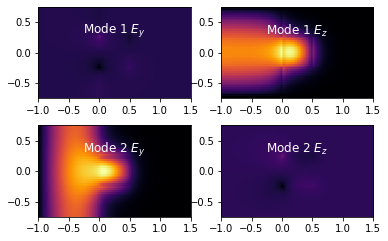

In [17]:
# Add bulk oxide below

mode.switchtolayout() 

custom = "<Object defined dielectric>"
refractive_index = 1.3 # Index < glass

mode.addrect()
mode.set('name','bulk')

mode.setnamed('bulk','z max', 0)
mode.setnamed('bulk','z min', -5e-6)
mode.setnamed('bulk','y', 0)
mode.setnamed('bulk','y span', 10e-6)
mode.setnamed('bulk','x', 0)
mode.setnamed('bulk','x span', 20e-6)

mode.set('material',custom)
mode.set('index',refractive_index)

mode.findmodes()

fig, ax = plt.subplots(2,2)

# Mode 1
Ey = np.reshape(mode.getdata("MODE::data::mode1","Ey"), ( np.shape(y)[0], np.shape(z)[0]))
Ez = np.reshape(mode.getdata("MODE::data::mode1","Ez"), ( np.shape(y)[0], np.shape(z)[0]))


ax[0,0].imshow(np.real(Ey), extent =simulation_area, cmap='inferno',vmax=1 )
ax[0,0].text(0.25,0.5, 'Mode 1 $E_y$', c = 'w',  horizontalalignment='center',verticalalignment='top',fontsize = 12)

ax[0,1].imshow(np.real(Ez), extent =simulation_area, cmap='inferno',vmax=1 )
ax[0,1].text(0.25,0.5, 'Mode 1 $E_z$', c = 'w',  horizontalalignment='center',verticalalignment='top',fontsize = 12)


# Mode 2
Ey = np.reshape(mode.getdata("MODE::data::mode2","Ey"), ( np.shape(y)[0], np.shape(z)[0]))
Ez = np.reshape(mode.getdata("MODE::data::mode2","Ez"), ( np.shape(y)[0], np.shape(z)[0]))

ax[1,0].imshow(np.real(Ey),extent =simulation_area, cmap='inferno' ,vmax=1)
ax[1,0].text(0.25, 0.5, 'Mode 2 $E_y$', c = 'w',  horizontalalignment='center',verticalalignment='top',fontsize = 12)

ax[1,1].imshow(np.real(Ez),extent =simulation_area, cmap='inferno' ,vmax=1)
ax[1,1].text(0.25, 0.5, 'Mode 2 $E_z$', c = 'w',  horizontalalignment='center',verticalalignment='top',fontsize = 12)

plt.show()
